In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import dask
import xarray as xr
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

import sys
sys.path.append("../BBTRE_physics_analysis/") 
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [154]:
# Constant parameters

Γ = 0.0005096839959
N = np.sqrt(g*α*Γ)
θ = 2.0E-3
f = -5.3e-5

k0 = 5.e-5

dx = 100.; dy = 100.
delta_t = 30

In [269]:
data_dir = f"/nobackup1/hdrake/Ruan-test/MITgcm_combined/test_2e-3/run/"
diter = 3600
iters = np.arange((86400*50)//delta_t+(diter//2)//delta_t, (86400*100)//delta_t+(diter//2)//delta_t, diter//delta_t)
temp = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "KL10Diag"], delta_t=delta_t).rename({'KLdiffKr': 'KVDIFF'})
temp, grid = add_rotated_coords(temp, θ)
temp = add_hab_coordinates(temp, grid, vert_coord='Zl', gridface='C')
temp['KVDIFF_hab'] = hab_interp(temp['KVDIFF'], vert_coord='Zl', gridface='C', hab_bins=np.arange(2.5, 4000., 5.0))

av_diter = 43200
av_iters = np.arange((86400*50)//delta_t, (86400*100)//delta_t, av_diter//delta_t)
av = open_mdsdataset(data_dir,iters=av_iters,ignore_unknown_vars=True,prefix=["meanDiag"], delta_t=delta_t)
av, grid = add_rotated_coords(av, θ)
av = add_hab_coordinates(av, grid, vert_coord='Z', gridface='W')
av['UVEL_hab'] = hab_interp(av['UVEL'], gridface='W', hab_bins=np.arange(2.5, 4000., 5.0))

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [285]:
k1 = temp['KVDIFF_hab'].mean('time').max().values
k1mean = temp['KVDIFF_hab'].mean(['time', 'YC', 'XC']).max().values

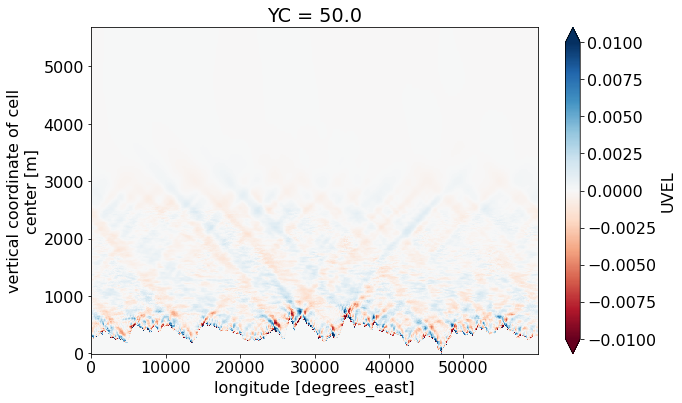

In [156]:
av['UVEL'].mean('time').plot(vmin=0.01, vmax=-0.01, cmap='RdBu')

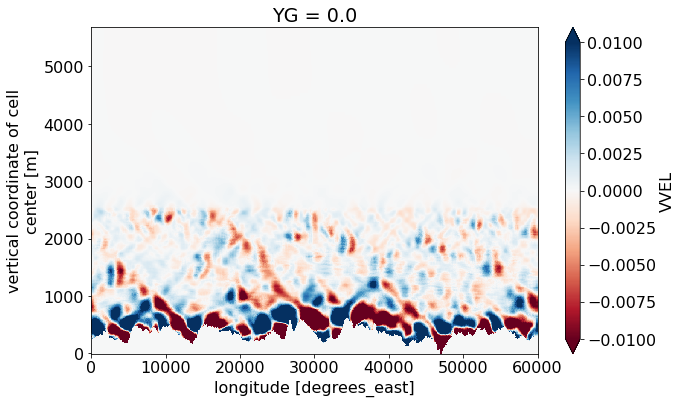

In [157]:
av['VVEL'].mean('time').plot(vmin=0.01, vmax=-0.01, cmap='RdBu')

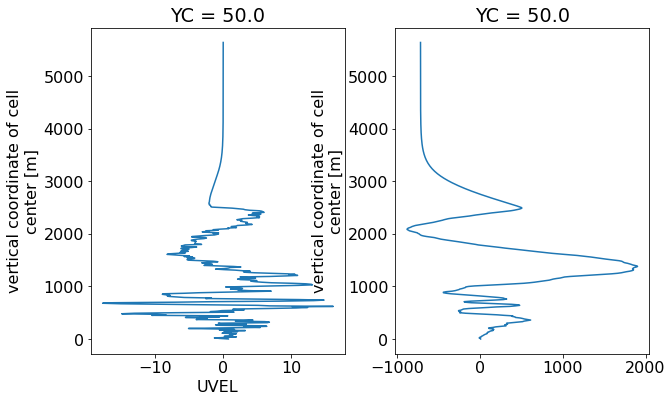

In [158]:
plt.subplot(1,2,1)
av['UVEL'].sum(['time', 'XG'], skipna=True).plot(y='Z')
plt.subplot(1,2,2)
(av['UVEL'].sum(['time', 'XG'], skipna=True)*av['drF'])[::-1].cumsum('Z')[::-1].plot(y='Z')

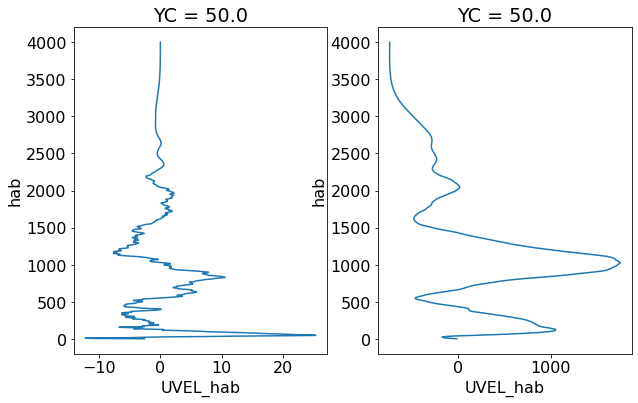

In [159]:
plt.subplot(1,2,1)
av['UVEL_hab'].sum(['time', 'XG'], skipna=True).plot(y='hab')
plt.subplot(1,2,2)
(av['UVEL_hab'].sum(['time', 'XG'], skipna=True)*5.).cumsum('hab').plot(y='hab')

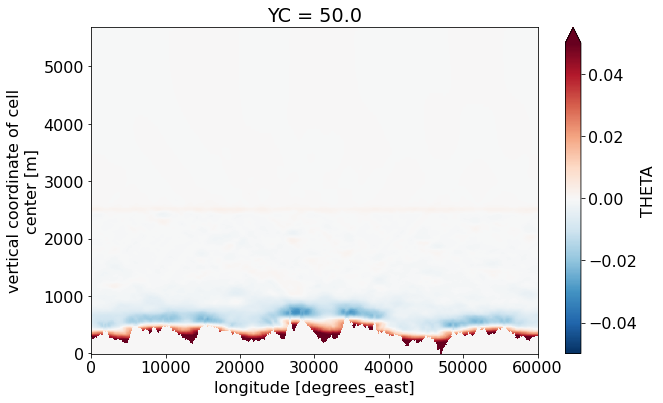

In [160]:
av['THETA'].mean(['time']).plot(vmin=-0.05, vmax=0.05, cmap='RdBu_r')

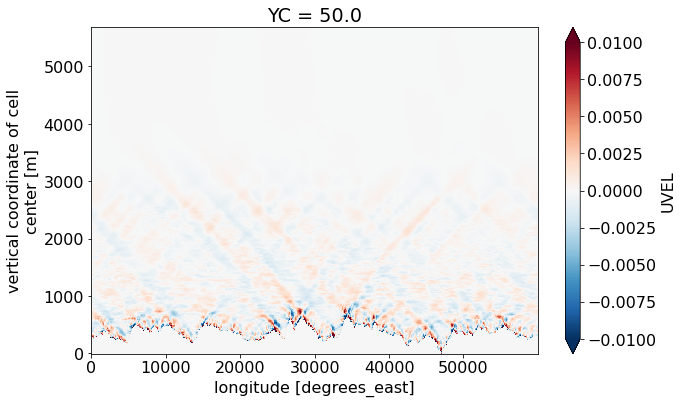

In [161]:
av['UVEL'].mean(['time']).plot(vmin=-0.01, vmax=0.01, cmap='RdBu_r')

### WMT

In [266]:
iters = np.arange((86400*50)//delta_t+(diter//2)//delta_t, (86400*100)//delta_t+(diter//2)//delta_t, diter//delta_t)
wmt = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "KL10Diag"], delta_t=delta_t)
wmt = wmt.rename({'KLdiffKr': 'KVDIFF'})

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


KeyboardInterrupt: 

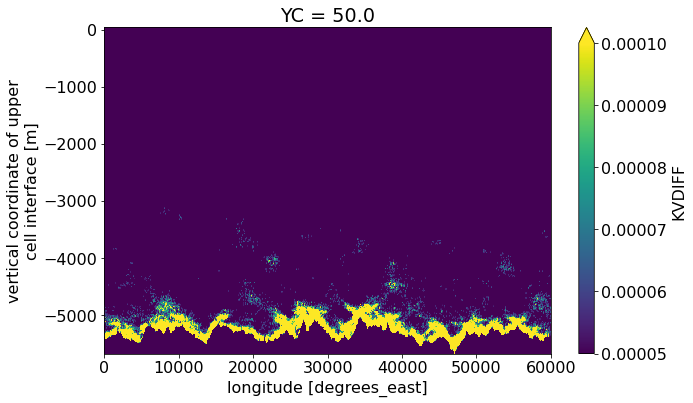

In [256]:
wmt['KVDIFF'].mean('time').plot(vmax=1.e-4)

In [258]:
extend_multiples=[-15,12]
wmt = periodic_extend(wmt, ['XC', 'XG'], dx, extend_multiples)

In [259]:
wmt, wmt_grid = add_rotated_coords(wmt, θ)
wmt = add_temp_budget(wmt, wmt_grid, Γ, θ)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


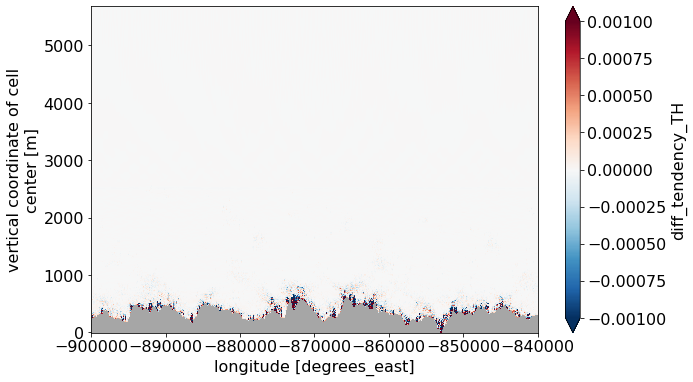

In [260]:
wmt['diff_tendency_TH'].isel(XC=slice(0,600)).mean(['time', 'YC']).plot(vmin=-0.001, vmax=0.001, cmap='RdBu_r')

In [261]:
wmt['THETA_BG_C'] = Γ*wmt['Zr']
wmt['θ'] = wmt['THETA'] + wmt['THETA_BG_C']
wmt['θ'] = wmt['θ'].where(wmt['hFacC'] != 0)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(-250.0, 2250.0)

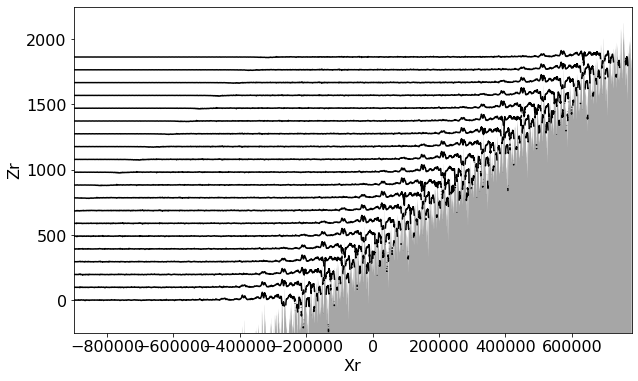

In [262]:
wmt['θ'].mean(['time', 'YC']).plot.contour(x='Xr', y='Zr', levels=np.arange(0,1.,0.05), colors='k')
plt.fill_between(wmt['XC'], 0.*wmt['XC']-1000, -wmt['Depthr'].mean('YC')+wmt.attrs['H'], facecolor=nancol)
#plt.xlim([-60e3, 120e3])
plt.ylim([-250, 2250])

In [ ]:
ds = wmt

dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

mixing = ds['diff_tendency_TH'].fillna(0.)
T = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing,
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

TBBL = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing.where(mixing > 0., 0.),
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

TSML = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=mixing.where(mixing < 0., 0.),
    dim=('XC', 'YC', 'Z',)
).load()/dθ;

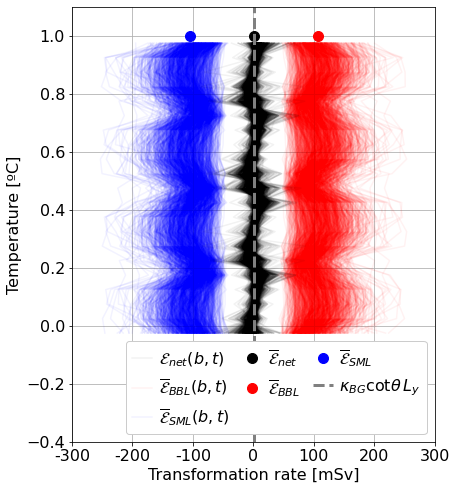

In [289]:
Lx, Ly = temp.XC.size*dx, temp.YC.size*dy
cint = k0*Γ*np.cos(θ)*Ly*Lx
cbot = k1*Γ*np.cos(θ)*Ly*Lx

plt.figure(figsize=(6.5, 8))
for i, t in enumerate(T.time.values):
    if i==0:
        T.sel(time=t).plot(y='θ_bin', color="k", label=r"$\mathcal{E}_{net}(b, t)$", alpha=0.05)
        TBBL.sel(time=t).plot(y='θ_bin', color="r", label=r"$\overline{\mathcal{E}}_{BBL}(b, t)$", alpha=0.05)
        TSML.sel(time=t).plot(y='θ_bin', color="b", label=r"$\overline{\mathcal{E}}_{SML}(b, t)$", alpha=0.05)
    else:
        T.sel(time=t).plot(y='θ_bin', color="k", alpha=0.05)
        TBBL.sel(time=t).plot(y='θ_bin', color="r", alpha=0.05)
        TSML.sel(time=t).plot(y='θ_bin', color="b", alpha=0.05)

plt.plot([T.mean(['θ_bin', 'time'])],[1.0], "ko", markersize=10, label=r"$\overline{\mathcal{E}}_{net}$")
plt.plot([TBBL.mean(['θ_bin', 'time'])],[1.0], "ro", markersize=10, label=r"$\overline{\mathcal{E}}_{BBL}$")
plt.plot([TSML.mean(['θ_bin', 'time'])],[1.0], "bo", markersize=10, label=r"$\overline{\mathcal{E}}_{SML}$")

plt.axvline(x=cint/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = "--", label=r"$\kappa_{BG}\cot{\theta}\, L_{y}$")
# plt.axvline(x=cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":", label=r"$\pm \kappa_{Bot}\cot{\theta}\, L_{y}$")
# plt.axvline(x=-cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":")

plt.xlabel("Transformation rate [mSv]")
plt.ylabel("Temperature [ºC]")
xticks = np.arange(-300e3, 320e3, 100e3)
plt.xticks(xticks/(60e3/Ly), (xticks*1e-3).astype(np.int64));
plt.grid(True)
plt.ylim([-0.4, 1.1])
plt.title("")
plt.legend(loc='lower right', ncol=3, handlelength=1.25, framealpha=1., handletextpad=0.4, columnspacing=0.8)
plt.savefig("../../figures/BBTRE/wmt_tidally-driven.png")